In [1]:
import pandas as pd, numpy as np
import QTLfunctions as QTLfun
import information as info

from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
## Set relative regions of MAT locus
MAT = [1529240,1661861]

## Bring in centromeres datarame
cent_path = '/home/croth/Downloads/B3502/DATA/FungiDB-48_CneoformansJEC21_centromeres.csv'
centlocs = pd.read_csv(cent_path,index_col=0)

## Bring in chromosome map
chrommap_path = '/home/croth/Downloads/B3502/DATA/chrommap.csv.gz'
chrommap = pd.read_csv(chrommap_path)
chrommap['Seqid'] = chrommap.Contig
chrommap.drop('Contig',axis=1,inplace=True)
chrommap['Chromosome'] = chrommap.index+1
chrommap = chrommap.merge(centlocs)
chrommap.tail()

,Length,Cumlen,Midpts,Seqid,Chromosome,Left,Right
9,1085720,14488944,15031804.0,AE017350.1,10,807373,880180
10,1019846,15574664,16084587.0,AE017351.1,11,144778,180133
11,906719,16594510,17047869.5,AE017352.1,12,146899,171065
12,787999,17501229,17895228.5,AE017353.1,13,121986,179214
13,762694,18289228,18670575.0,AE017356.1,14,566417,639012


In [3]:
## Bring in genotype dataframe
genopath = '../GENOTYPE/B3502_progeny_variants.csv.gz'
geno = pd.read_csv(genopath,
                   index_col=0)
geno.head()

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,...,B04,B05,B06,B07,B08,B09,B10,B11,B12,B20
7713,AE017341.1,530127,87856.4,1.0,1,C.G,1,1,5440,snp,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
13742,AE017341.1,884617,51253.4,1.0,1,AGG.AGA,3,3,3444,snp,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
16507,AE017341.1,1032506,76943.9,1.0,1,T.C,1,1,5283,snp,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
22088,AE017341.1,1430787,11823.5,1.0,1,G.T,1,1,4119,snp,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25519,AE017341.1,1694543,80782.5,1.0,1,G.C,1,1,5795,snp,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [4]:
## Bring in phenotype data from Dr. Sheng Sun
phenopath = '../PHENOTYPE/202011_WGS_B3502Progeny_phenotypes.csv.gz'
pheno = pd.read_csv(phenopath)
pheno.index = pheno.Strain
pheno.tail()

,Cross_Progeny,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Phenotype,Strain
Strain,,,,
B09,1. B3502A1_x_CF830_Random12,N,0.0,B09
B10,1. B3502A1_x_CF830_Random14,N,0.0,B10
B11,1. B3502A1_x_CF830_Random20,T,2.0,B11
B12,2. B3502B1_x_CF830_Random01,N,0.0,B12
B20,2. B3502B1_x_CF830_Random12,Y,1.0,B20


In [5]:
## Make additional phenotype groups 
## by binning Dr Sun's scores
## Define binning dictionarys
bidict = dict(zip([0,1,2,3],[0,1,1,1]))
tridict = dict(zip([0,1,2,3],[0,1,1,2]))

## Replace scores
pheno['Binary'] = pheno.Phenotype.replace(bidict)
pheno['Tertiary'] = pheno.Phenotype.replace(tridict)

## View restuls
pheno[[pheno.columns[2],'Phenotype','Binary','Tertiary']].drop_duplicates()

,Phenotype,Phenotype,Binary,Tertiary
Strain,,,,
A01,0.0,0.0,0.0,0.0
A02,1.0,1.0,1.0,1.0
A04,3.0,3.0,1.0,2.0
A09,2.0,2.0,1.0,1.0


In [6]:
## Gather samples and unique testing sites
samples_wc = sorted(pheno.Strain.tolist())
clone_drop = ['A44','A24'] #['A27','A43']
samples = [s for s in samples_wc if s not in clone_drop]
len(samples)

55

In [7]:
## Gather unique haplotypes for testing
loci = geno[samples].drop_duplicates()
loci.shape

(59, 55)

In [8]:
## Here I have set the phenotype to a quadriaary phenotype
## Uncomment this to analyze a binary phenotype
## Filamentous vs nonfilamentous vs large cells
#pheno_label = 'Phenotype'
#pheno_label = 'Binary'
pheno_label = 'Tertiary'

## Copy loci df and append phenotype set above
usnps = loci.copy().T
Y = pheno.loc[samples,pheno_label]
usnps['Y'] = Y
usnps.shape

(55, 60)

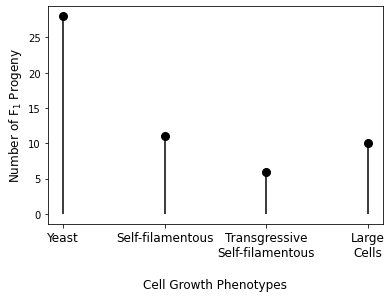

In [9]:
## Plot distribution of phenotypes
x,y = np.unique(pheno.loc[samples,'Phenotype'].values,return_counts=True)
fig,ax = plt.subplots(1,1,figsize=(6,4))
fig.set_facecolor('w')
plt.vlines(x,0,y,color='k');
plt.plot(x,y,'o',color='k',ms=8);
#plt.xticks(x,['No','Yes','Transgressive','Large\nCell'],fontsize=12)
plt.xticks(x,['Yeast','Self-filamentous',
              'Transgressive\nSelf-filamentous',
              'Large\nCells'],
          fontsize=12)
plt.xlabel('\nCell Growth Phenotypes',fontsize=12)
plt.ylabel('Number of F$_1$ Progeny',fontsize=12);
plt.savefig('../FIGURES/Filamentous_phenotypes_hist.png',
            dpi=200,bbox_inches='tight');

In [10]:
## QTL map using mutual information measure
res = QTLfun.QTLmap(geno,
                    info.mutual_information,
                    samples,Y[samples].values)

In [11]:
## permute mutual information
thres = 0.16507851056671202
perms = []
nperm = 10000

if thres is None:

    thres, perms = QTLfun.QTLperm(geno,
                                 info.mutual_information,
                                 samples,
                                 Y[samples].values,
                                 n=nperm)
    
## Plot null distribution of association
if (thres is not None) and (len(perms)==nperm):

    plt.hist(perms,alpha=0.5,color='grey');
    plt.xlabel('$I$ ( G$_n$; F )',fontsize=12);
    plt.ylabel('Number of Permutations',fontsize=12);
    plt.title('Null Distribution of Association',fontsize=12);
    plt.vlines(thres,0,nperm/6,color='r',alpha=0.5);
    plt.text(thres,nperm/6,'\u03B1 = 0.01',fontsize=12,
         color='k',alpha=0.5,va='bottom',ha='center')
    plt.savefig('../FIGURES/IG_null_dist.png',
            dpi=100,bbox_inches='tight');

In [12]:
## Color map
color_map = ['tab:purple','tab:green','tab:orange',
             'tab:brown',
             'lightblue','tab:grey','tab:blue']

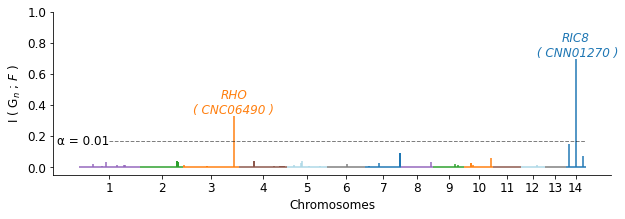

In [13]:
## Make a Manhttan plot for the fialamintation QTL
fig,ax = plt.subplots(1,1,figsize=(10,3))
fig.set_facecolor('w')
qtl3name = 'RHO\n( CNC06490 )'
qtl14name = 'RIC8\n ( CNN01270 )'
for i,(j,c) in enumerate(chrommap.iterrows()):
    
    plt.hlines(0,c.Cumlen,c.Cumlen+c.Length,
               linestyle='-',
               #color = 'k' if i%2 == 0 else 'lightgrey')
               color=color_map[i%len(color_map)])
    
    temp = res[(res.Chrom==c.Chromosome)]
    plt.vlines(temp.Pos+c.Cumlen,0,temp.QTL,
               #color='k' if i%2 == 0 else 'lightgrey')
               color=color_map[i%len(color_map)])
    
    if c.Chromosome in [3,14]:
        
        qtlm = temp.loc[temp.QTL.idxmax,['Pos','QTL']]
        plt.text(qtlm.Pos+c.Cumlen,qtlm.QTL.max(),
                 va='bottom',ha='center',fontsize=12,
                 s=qtl3name if c.Chromosome==3 else qtl14name,
                style='italic',
                 color=color_map[i%len(color_map)])
        
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
plt.xticks(chrommap.Midpts,chrommap.Chromosome,fontsize=12)
plt.ylabel('I ( G$_n$ ; $F$ )',fontsize=12)
plt.ylim(-0.05,1)
plt.xlabel('Chromosomes',fontsize=12)
plt.text(x=chrommap.Length.tolist()[0]/2,
         y=thres,s='\u03B1 = 0.01',
         ha='right',va='center',fontsize=12)

plt.yticks(fontsize=12)
plt.hlines(thres,np.min(chrommap.Cumlen.tolist()[1:])/2,
           c.Cumlen+c.Length, color='k',
           linestyle='--',linewidth=1,alpha=0.5);
plt.savefig('../FIGURES/Filamentous_Mutual_information_manhattan.png',
           dpi=200,bbox_inches='tight');

In [14]:
## Find loci above threshold
sigloci = res[(res.QTL>=thres)]
sigloci

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,...,B05,B06,B07,B08,B09,B10,B11,B12,B20,QTL
485,AE017343.1,1894056,98227.7,1.0,1,G.A,1,1,5098,snp,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.328123
1924,AE017356.1,388780,80970.8,1.0,1,G.T,1,1,5055,snp,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.692982


In [15]:
## append Genotypes of QTL and MAT
pheno['RIC8'] = sigloci[(sigloci.Chrom==14)][pheno.index].values[0]
pheno['QTL3'] = sigloci[(sigloci.Chrom==3)][pheno.index].values[0]
pheno['MAT'] = geno[(geno.Chrom==4) & 
                    (geno.Pos>=np.min(MAT)) & 
                    (geno.Pos<=np.max(MAT))][pheno.index].min()

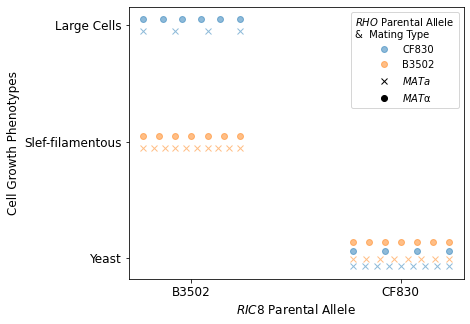

In [16]:
## Make a phenotype by genotype plot
fig,ax = plt.subplots(1,1,figsize=(6,5))
fig.set_facecolor('w')
## Set ylabels
#yphenos = ['Non-filamentous','Filamentous','Large Cells']
yphenos = ['Yeast','Slef-filamentous','Large Cells']
y = pheno.loc[samples,'Tertiary'].values

## Gather QTL genotypes
## QTL14 allele
ric8 = pheno.loc[samples,'RIC8']
## QTL3 allele
rho = pheno.loc[samples,'QTL3']
## Gather MAT locus
mat = pheno.loc[samples,'MAT']
#geno[(geno.Chrom==4) & (geno.Pos>=np.min(MAT)) & 
#     (geno.Pos<=np.max(MAT))][samples].min().to_numpy()
for i in [0,1]:
    for j in [0,1]:
        for m in [0,1]:
            gix = (ric8==i) & (rho==j) & (mat == m)
        
            if (i+m == 2) and (j == 0) :
                mylabel = 'CF830'#+'$^{RHO}$'
            elif (i+m ==2) and (j == 1):
                mylabel = 'B3502'#+'$^{RHO}$'
            else:
                mylabel = None
                
            xjitter = np.linspace(-0.23,0.23,np.sum(gix)) 
            
            if (i==0):
                yjitter = np.array([-0.07,-0.01,0.06,0.14])[j+2*m]
            else:
                yjitter = np.array([-0.05,0.05])[m]
            
            plt.plot((1 - ric8[gix])+xjitter,y[gix]+yjitter,
                     'o' if m == 1 else 'x',
                     alpha= .5,label = mylabel,
                     color='tab:blue' if j == 0 else 'tab:orange')
            
plt.plot(1,1,'kx',alpha=1,label='$MATa$');
plt.plot(1,1,'ko',alpha=1,label='$MAT$'+'\u03B1');
plt.plot(1,1,'wo',ms=10)

plt.legend(loc=0,frameon=True,
           title='$RHO$ Parental Allele \n&  Mating Type')
plt.yticks(sorted(np.unique(y)),yphenos,fontsize=12)
plt.ylabel('Cell Growth Phenotypes',fontsize=12);
plt.xticks([0,1],['B3502','CF830'],fontsize=12)
plt.xlim(-0.3,1.3);
plt.xlabel('$RIC8$ Parental Allele',fontsize=12);
plt.savefig('../FIGURES/Filamentous_by_QTL.png',
            dpi=200,bbox_inches='tight')

In [17]:
genech = pd.read_csv('/home/croth/Downloads/B3502/DATA/gene_changes.csv.gz')

In [2]:
genech[(genech.Gene=='CNA05340')]

NameError: name 'genech' is not defined

In [19]:
genech[(genech.Gene=='CNC06490')]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chromosome,Seqid,Start,End,Strand,Description
365,B3502_A1_Stock1,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
366,B3502_A7_Stock2,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
367,B3502_B1_Stock3,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
368,B3502_B7_Stock4,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
369,B3502_C1_Stock5,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
370,B3502_C1_Stock7,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
371,B3502_D1_Stock6,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,0,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
372,CF830,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,0,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
373,JEC20,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,0,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
374,JEC21,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,0,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
